# Preparação das Bases

In [1]:
# Importa bibliotecas
import requests
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.ensemble import GradientBoostingClassifier

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
# Importa Base de Dados
df_ml = pd.read_csv('clean.csv', sep = ";")
df_ml.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Substitui variaveis descritivas
df_ml['id_geography'] = df_ml['Geography'].replace({'France': 0, 'Spain': 1, 'Germany': 2})
df_ml['id_gender'] = df_ml['Gender'].replace({'Female': 0, 'Male': 1})

In [ ]:
# Exclui colunas que nao serao utilizadas no modelo
# df_ml = df_ml.drop(columns=["Surname", "RowNumber", "Geography", "Gender"])

# Construção dos Modelos

### Definição da variáveis de treino e de teste

In [ ]:
# definindo a aleatoriedade para separação das bases de treino e de teste
SEED = 5
np.random.seed(SEED)

In [ ]:
# Separa os dados em features e target
x = df_ml[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "id_geography", "id_gender"]] # Features
y = df_ml["Exited"] # Target variable

Base possue grande desproporcionalidade entre os valores de churn positivo e churn negativo, por isso o balanceamento é necessário.

In [ ]:
# Usa SMOTE() para balancear a divisao entre número de churn positivos e de negativos
treino_x, treino_y = SMOTE().fit_resample(x, y)

In [ ]:
print("Contagem de classes antes do balanceamento:")
print(y.value_counts())
 
print("\nContagem de classes após o balanceamento:")
print(treino_y.value_counts())

Contagem de classes antes do balanceamento:
Exited
0    7934
1    2017
Name: count, dtype: int64

Contagem de classes após o balanceamento:
Exited
1    7934
0    7934
Name: count, dtype: int64


In [ ]:
# Divide de variaveis de treino e de teste (features e target)
treino_x, teste_x, treino_y, teste_y = train_test_split(treino_x, 
                                                        treino_y, 
                                                        random_state=SEED, 
                                                        test_size=0.3)

In [ ]:
# Escala as duas variáveis
scaler = MinMaxScaler(feature_range=(0, 1))
treino_x = scaler.fit_transform(treino_x)
teste_x = scaler.fit_transform(teste_x)

### XGBOOST

In [ ]:
# Modelo XGBOOST
xgboost = XGBClassifier()

In [ ]:
# Hiperparâmetros XGBOOST utilizando BayesSearchCV
param_space_xgboost = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 50),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(0, 5)
}

# Instância do BayesSearchCV
bayes_xgboost = BayesSearchCV(
    estimator=xgboost,
    search_spaces=param_space_xgboost,
    n_iter=50,    
    cv=3,         
    scoring='accuracy',  
    n_jobs=-1     
)


In [ ]:
# Rodando modelo com hiperparametros definidos
bayes_xgboost.fit(treino_x, treino_y)
previsoes_xgboost = bayes_xgboost.predict(teste_x)

In [ ]:
# Acuracia xgboost
acuracia_xgboost = accuracy_score(teste_y, previsoes_xgboost) * 100
print("A acurácia foi de: %.2f%%" % acuracia_xgboost)

A acurácia foi de: 85.80%


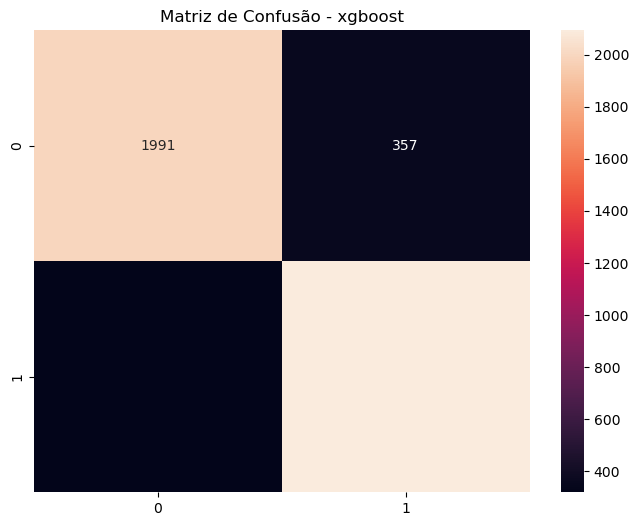

In [ ]:
# Matriz de confusao XGBOOST
y_true_xgboost = teste_y
y_pred_xgboost = previsoes_xgboost
matriz_de_confusao_xgboost = confusion_matrix(y_true_xgboost, y_pred_xgboost) 
 
plt.figure(figsize=(8, 6))
 
sns.heatmap(matriz_de_confusao_xgboost, annot=True, fmt='d')
 
plt.title('Matriz de Confusão - xgboost')
plt.show()

In [ ]:
matriz_de_confusao_xgboost

array([[1991,  357],
       [ 319, 2094]], dtype=int64)

In [ ]:
# Recall XGBOOST
recall_xgboost = recall_score(teste_y, previsoes_xgboost) * 100
print("A taxa de Recall do xgboost foi de: %.2f%%" % recall_xgboost)

A taxa de Recall do xgboost foi de: 86.78%


# Integração EYQ

In [ ]:
# More secure way
# incubator_endpoint = os.getenv("EYQ_INCUBATOR_ENDPOINT")
# incubator_key = os.getenv("EYQ_INCUBATOR_KEY")
# Less secure way
incubator_endpoint = "https://eyqincubator.america.fabric.ey.com/eyq/canadaeast/api/"
incubator_key = "toNx9GPyvXRB9C6sDC8G47XAO2IKGeZV"
api_version = "2023-05-15"
model = "gpt-4"  # Replace with desired model
headers = {
    "x-api-key": incubator_key
}
query_params = {
    "api-version": api_version
}

 
def chat(prompt):
    body = {
        "messages":[
            {"role": "system", "content": "Você é um especilista do banco, e sua tarefa é personalizar mensagens para os reter os clientes."},
            {"role":"user","content": prompt}
        ]
    }
 
    full_path = incubator_endpoint + "/openai/deployments/" + model + "/chat/completions"
 
    response = requests.post(full_path, json=body, headers=headers, params=query_params)
 
    response = response.json()
 
    body["messages"].append({"role": "system", "content": response["choices"][0]["message"]["content"]})
 
    return response["choices"][0]["message"]["content"]